In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [80]:
df = pd.read_excel('dados_credito.xlsx')
df.head()

,CODIGO_CLIENTE,UF,IDADE,ESCOLARIDADE,ESTADO_CIVIL,QT_FILHOS,CASA_PROPRIA,QT_IMOVEIS,VL_IMOVEIS,OUTRA_RENDA,OUTRA_RENDA_VALOR,TEMPO_ULTIMO_EMPREGO_MESES,TRABALHANDO_ATUALMENTE,ULTIMO_SALARIO,QT_CARROS,VALOR_TABELA_CARROS,SCORE
0,1,SP,19,Superior Cursando,Solteiro,0,Não,0,0,Não,0,8,Sim,1800,0,0,12.000000
1,2,MG,23,Superior Completo,Solteiro,1,Não,0,0,Não,0,9,Não,4800,1,50000,18.000000
2,3,SC,25,Segundo Grau Completo,Casado,0,Sim,1,220000,Não,0,18,Sim,2200,2,30000,23.000000
3,4,PR,27,Superior Cursando,Casado,1,Sim,0,0,Não,0,22,Não,3900,0,0,28.666667
4,5,RJ,28,Superior Completo,Divorciado,2,Não,1,370000,Não,0,30,Sim,NaN,1,35000,34.166667


In [81]:
# Verificar tipo das variáveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10476 entries, 0 to 10475
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CODIGO_CLIENTE              10476 non-null  int64  
 1   UF                          10476 non-null  object 
 2   IDADE                       10476 non-null  int64  
 3   ESCOLARIDADE                10476 non-null  object 
 4   ESTADO_CIVIL                10476 non-null  object 
 5   QT_FILHOS                   10476 non-null  int64  
 6   CASA_PROPRIA                10476 non-null  object 
 7   QT_IMOVEIS                  10476 non-null  int64  
 8   VL_IMOVEIS                  10476 non-null  int64  
 9   OUTRA_RENDA                 10476 non-null  object 
 10  OUTRA_RENDA_VALOR           10476 non-null  int64  
 11  TEMPO_ULTIMO_EMPREGO_MESES  10476 non-null  int64  
 12  TRABALHANDO_ATUALMENTE      10476 non-null  object 
 13  ULTIMO_SALARIO              104

In [82]:
# Excluir CODIGO_CLIENTE
df.drop('CODIGO_CLIENTE', axis=1, inplace=True)

In [83]:
# Verificar se há algum valor anormal em ULTIMO_SALARIO
df.groupby('ULTIMO_SALARIO').size() # 1 Valor com "SEM DADOS"

ULTIMO_SALARIO
1800         846
2200         792
3100         792
3900         792
4500         468
4800         792
5300         522
6100         522
6800         611
9000         522
9800         468
11500        790
13000        522
15000        522
17500        522
18300        522
22000        468
SEM DADOS      1
dtype: int64

In [84]:
# Substituir "SEM DADOS" por null
df['ULTIMO_SALARIO'].replace('SEM DADOS', np.nan, inplace=True)
# Converter para float
df['ULTIMO_SALARIO'] = df['ULTIMO_SALARIO'].astype(float)

In [85]:
# Preencher os valores nulos com a mediana
df['ULTIMO_SALARIO'].fillna(df['ULTIMO_SALARIO'].median(), inplace=True)

In [86]:
print(df.isnull().sum()) # Não há mais valores nulos
print(df.dtypes) # Verificar os tipos das variáveis

UF                            0
IDADE                         0
ESCOLARIDADE                  0
ESTADO_CIVIL                  0
QT_FILHOS                     0
CASA_PROPRIA                  0
QT_IMOVEIS                    0
VL_IMOVEIS                    0
OUTRA_RENDA                   0
OUTRA_RENDA_VALOR             0
TEMPO_ULTIMO_EMPREGO_MESES    0
TRABALHANDO_ATUALMENTE        0
ULTIMO_SALARIO                0
QT_CARROS                     0
VALOR_TABELA_CARROS           0
SCORE                         0
dtype: int64
UF                             object
IDADE                           int64
ESCOLARIDADE                   object
ESTADO_CIVIL                   object
QT_FILHOS                       int64
CASA_PROPRIA                   object
QT_IMOVEIS                      int64
VL_IMOVEIS                      int64
OUTRA_RENDA                    object
OUTRA_RENDA_VALOR               int64
TEMPO_ULTIMO_EMPREGO_MESES      int64
TRABALHANDO_ATUALMENTE         object
ULTIMO_SALARIO     

In [87]:
# Detectar outliers
val_num = []
for i in df.columns:
    if df[i].dtypes != 'object':
        val_num.append(i)
        print(i, df[i].dtypes)

IDADE int64
QT_FILHOS int64
QT_IMOVEIS int64
VL_IMOVEIS int64
OUTRA_RENDA_VALOR int64
TEMPO_ULTIMO_EMPREGO_MESES int64
ULTIMO_SALARIO float64
QT_CARROS int64
VALOR_TABELA_CARROS int64
SCORE float64


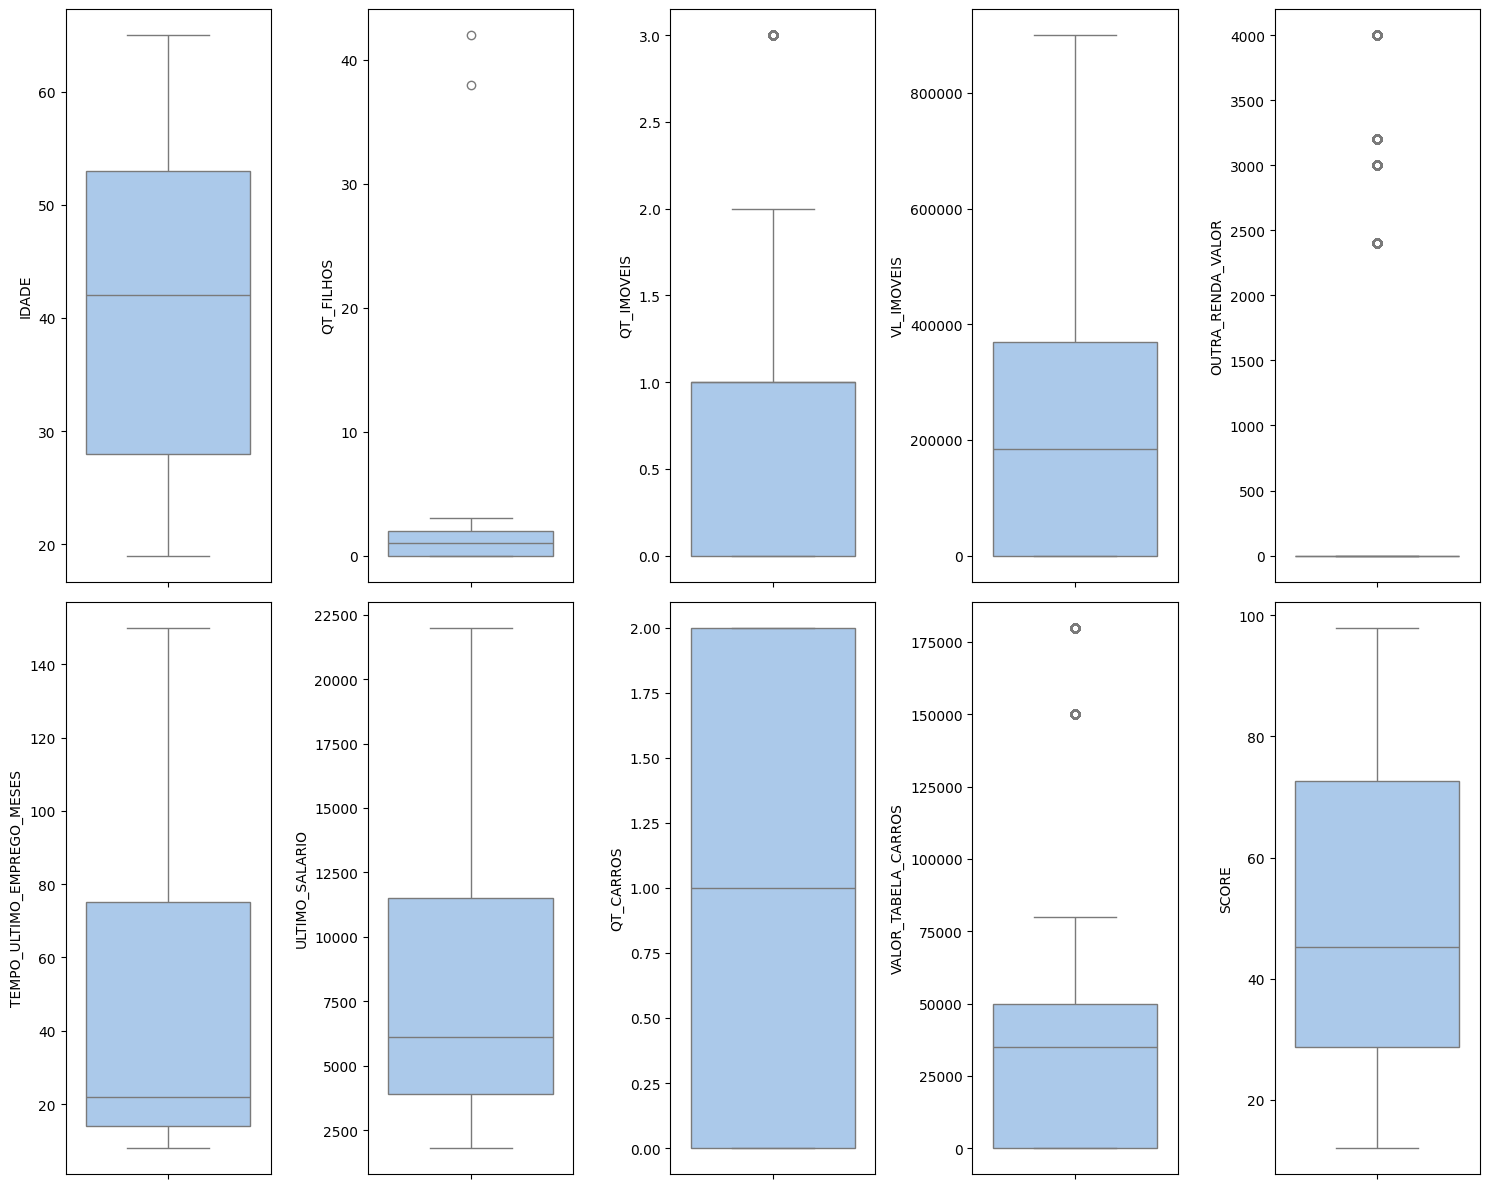

In [88]:
# Criar boxplot para cada variável numérica com subplot e seaborn
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['figure.autolayout'] = True
f, axes = plt.subplots(2, 5)
lin = 0
col = 0
for i in val_num:
    sns.boxplot(data=df, y=i, ax=axes[lin, col])
    col += 1
    if col == 5:
        lin += 1
        col = 0
        
plt.show() # Outliers em QT_FILHOS

In [89]:
# Listar os outliers de QT_FILHOS, acima de 4
print(df[df['QT_FILHOS'] > 4])
# Remover os outliers
df.drop(df[df['QT_FILHOS'] > 4].index, inplace=True)

       UF  IDADE           ESCOLARIDADE ESTADO_CIVIL  QT_FILHOS CASA_PROPRIA  \
27     SP     48      Superior Completo   Divorciado         38          Sim   
10455  SP     45  Segundo Grau Completo       Casado         42          Sim   

       QT_IMOVEIS  VL_IMOVEIS OUTRA_RENDA  OUTRA_RENDA_VALOR  \
27              2      600000         Não                  0   
10455           1      220000         Não                  0   

       TEMPO_ULTIMO_EMPREGO_MESES TRABALHANDO_ATUALMENTE  ULTIMO_SALARIO  \
27                             15                    Sim         15000.0   
10455                          18                    Sim          2200.0   

       QT_CARROS  VALOR_TABELA_CARROS      SCORE  
27             1                70000  67.166667  
10455          2                30000  23.000000  


In [90]:
# Verificar demais variáveis numéricas atrás de outliers
for i in val_num:
    print(df[i].groupby(df[i]).size(), '\n')

IDADE
19    558
23    630
25    559
26      1
27    541
28    631
29      1
30    631
31      1
32    631
33      1
34      1
35    631
36      1
37      1
38      1
39      1
40      1
41      1
42    649
45    647
48    773
51    774
53    558
55    558
57    558
62    558
65    576
Name: IDADE, dtype: int64 

QT_FILHOS
0    3329
1    3726
2    2303
3    1116
Name: QT_FILHOS, dtype: int64 

QT_IMOVEIS
0    4680
1    3761
2     989
3    1044
Name: QT_IMOVEIS, dtype: int64 

VL_IMOVEIS
0         4680
185000     612
220000     791
280000     522
340000     522
370000     792
450000     990
600000     521
700000     522
900000     522
Name: VL_IMOVEIS, dtype: int64 

OUTRA_RENDA_VALOR
0       8350
2400     468
3000     612
3200     522
4000     522
Name: OUTRA_RENDA_VALOR, dtype: int64 

TEMPO_ULTIMO_EMPREGO_MESES
8      846
9      792
12     522
14     792
15     521
18     791
19     612
22     792
25     468
30     792
48     468
75     522
80     522
90     522
93     522
120    468


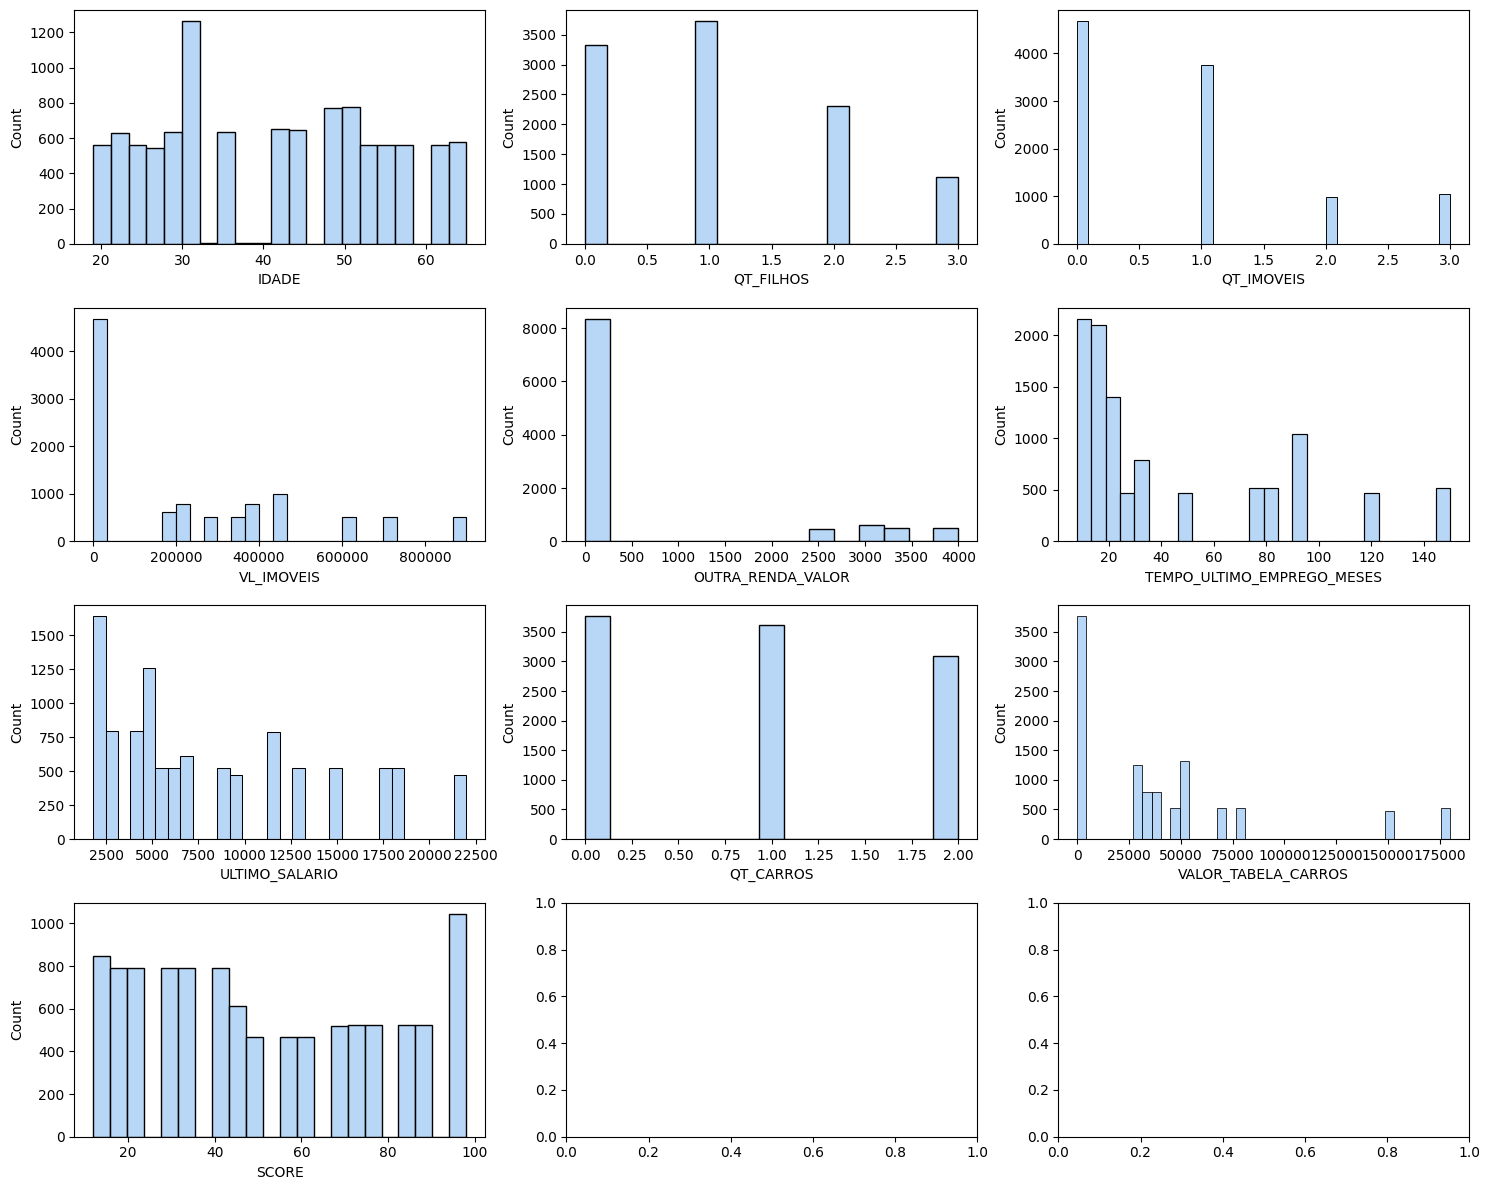

In [91]:
# Criação de histogramas para cada variável numérica
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['figure.autolayout'] = True
f, axes = plt.subplots(4, 3)
lin = 0
col = 0
for i in val_num:
    sns.histplot(data=df, x=i, ax=axes[lin, col])
    col += 1
    if col == 3:
        lin += 1
        col = 0
        
plt.show() # Variáveis com distribuição assimétrica, necessidade de transformação

<Axes: >

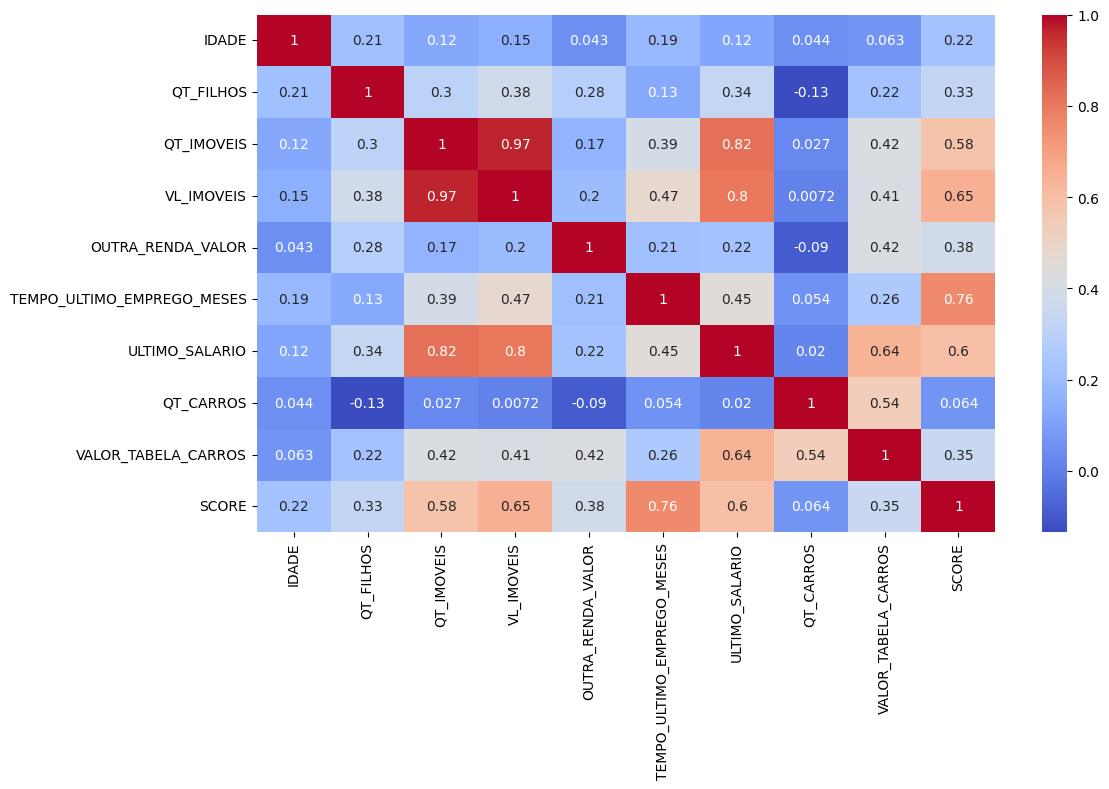

In [92]:
# Criação de heatmap para verificar correlação entre as variáveis numéricas
plt.figure(figsize=(12, 8))
sns.heatmap(df[val_num].corr(), annot=True, cmap='coolwarm')

In [93]:
# Agrupar idade em faixas etárias
df['FAIXA_ETARIA'] = pd.cut(df['IDADE'], bins=[0, 30, 40, 50, 60], labels=['18-30', '31-40','41-50', '50+'])
df['FAIXA_ETARIA'].value_counts()

FAIXA_ETARIA
18-30    3552
50+      2448
41-50    2070
31-40    1270
Name: count, dtype: int64

In [94]:
# Ver score médio por faixa etária
df.groupby('FAIXA_ETARIA')['SCORE'].mean()

C:\Users\higor\AppData\Local\Temp\ipykernel_952\1380639763.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('FAIXA_ETARIA')['SCORE'].mean()


FAIXA_ETARIA
18-30    44.762950
31-40    48.883202
41-50    51.440177
50+      56.123775
Name: SCORE, dtype: float64

UF object
ESCOLARIDADE object
ESTADO_CIVIL object
CASA_PROPRIA object
OUTRA_RENDA object
TRABALHANDO_ATUALMENTE object


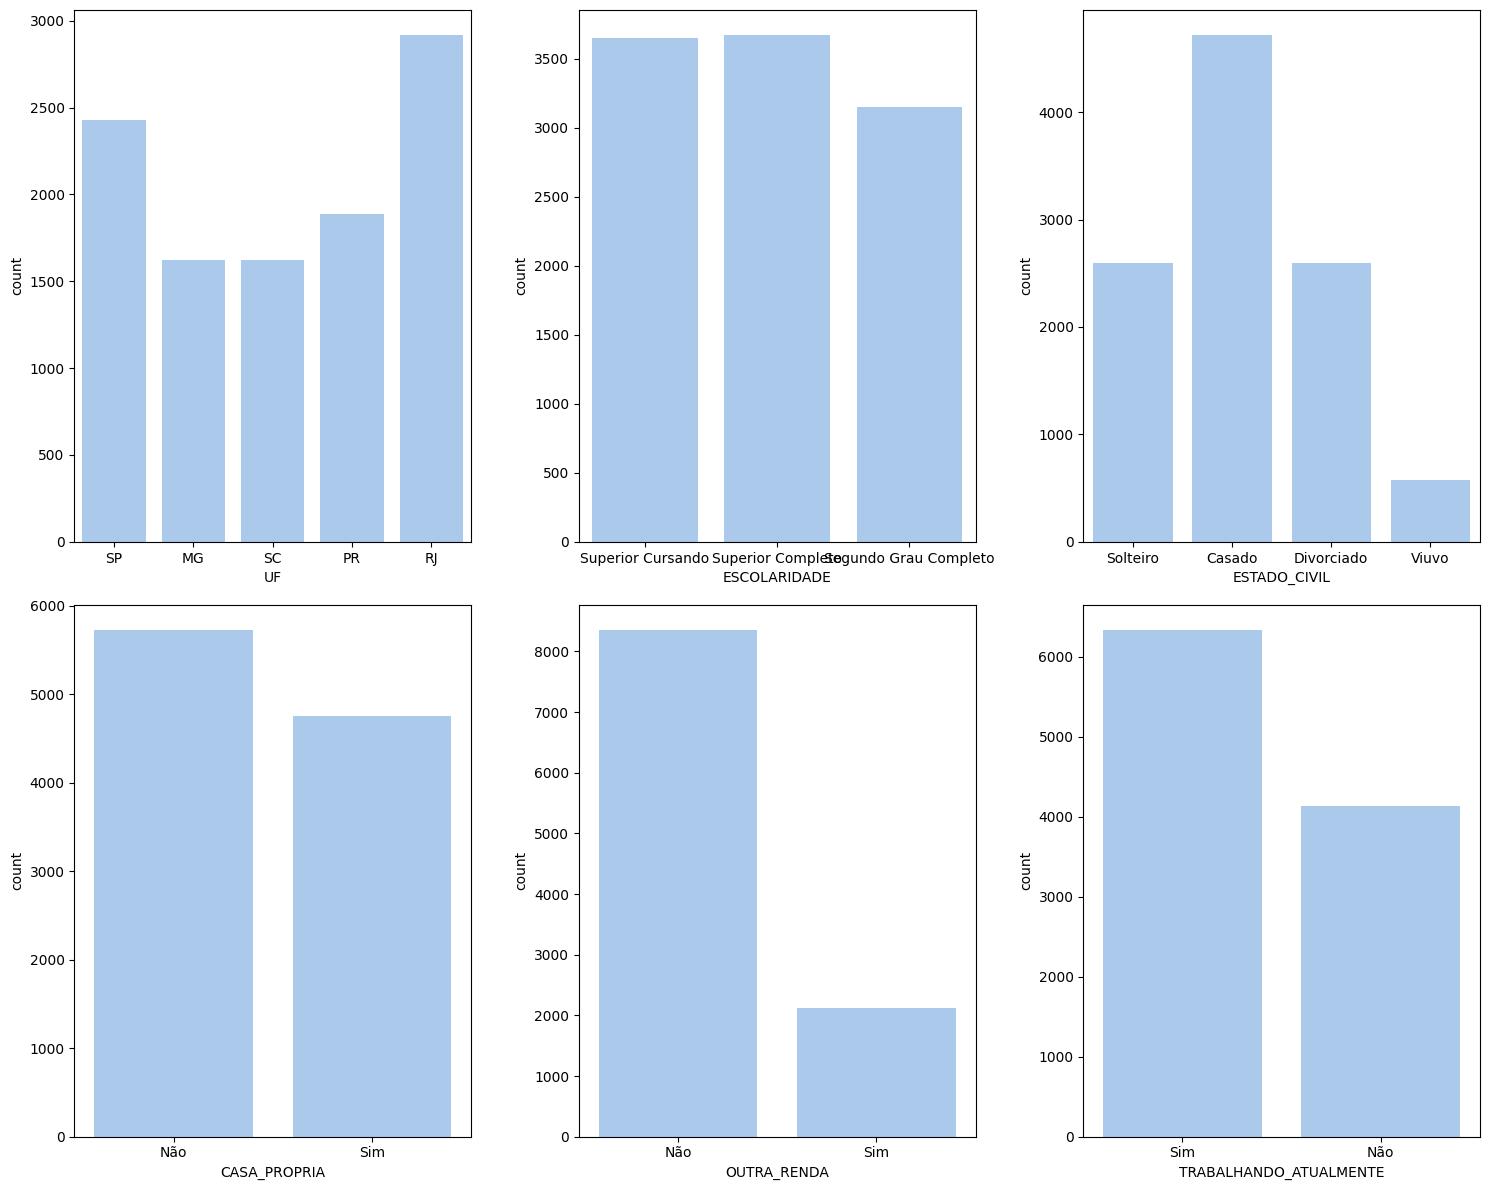

In [95]:
# Countplot para cada variável categórica
val_cat = []
sns.color_palette("tab10")
for i in df.columns:
    if df[i].dtypes == 'object':
        val_cat.append(i)
        print(i, df[i].dtypes)
        
f, axes = plt.subplots(2, 3)
lin = 0
col = 0
for i in val_cat:
    sns.countplot(data=df, x=i, ax=axes[lin, col])
    col += 1
    if col == 3:
        lin += 1
        col = 0

plt.show()

In [ ]:
# Codificação dos dados categóricos